In [1]:
pwd

'C:\\Users\\sarda\\Desktop'

In [2]:
pip install -r requirements_dev.txt      

  Obtaining dependency information for attrs==23.1.0 from https://files.pythonhosted.org/packages/f0/eb/fcb708c7bf5056045e9e98f62b93bd7467eb718b0202e7698eb11d66416c/attrs-23.1.0-py3-none-any.whl.metadata
  Using cached attrs-23.1.0-py3-none-any.whl.metadata (11 kB)
  Using cached autobahn-23.6.2.tar.gz (480 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached Automat-22.10.0-py2.py3-none-any.whl (26 kB)
  Obtaining dependency information for certifi==2023.5.7 from https://files.pythonhosted.org/packages/9d/19/59961b522e6757f0c9097e4493fa906031b95b3ebe9360b2c3083561a6b4/certifi-2023.5.7-py3-none-any.whl.metadata
  Using cached certifi-2023.5.7-py3-none-any.whl.metadata (2.2 kB)
  Obtaining dependency information for charset-normalizer==3.1.0 from https://files.pythonhosted.org/packages/ad/83/994bfca99e29f1bab66b9248e739360ee70b5aae0a5ee488cd776501edbc/charset_normalizer-3.1.0-cp311-cp311-win_amd64.whl.metadata
  Using c

ERROR: Could not find a version that satisfies the requirement smartapi-python==1.4.4 (from versions: 1.0.1, 1.0.2, 1.0.3, 1.0.3.1, 1.0.3.2, 1.0.3.3, 1.0.3.4, 1.0.4, 1.0.5, 1.0.5.1, 1.0.5.2, 1.0.5.3, 1.0.5.4, 1.0.5.5, 1.0.6, 1.1.0, 1.1.1, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.2.4, 1.2.5, 1.2.6, 1.2.7, 1.2.8, 1.2.9, 1.3.0, 1.3.1, 1.3.4, 1.3.5, 1.3.6, 1.3.7, 1.3.8, 1.3.9, 1.4.0, 1.4.1, 1.4.5)
ERROR: No matching distribution found for smartapi-python==1.4.4


In [3]:
pip install smartapi-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install websocket-client

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyotp

Note: you may need to restart the kernel to use updated packages.


In [23]:
#BASIC FETCHING OF HISTORIC DATA

In [6]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json

key_path=r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt","r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["name"]

def hist_data(tickers,duration,interval,instrument_list,exchange="NSE"):
    hist_data_tickers = {} 
    for ticker in tickers:
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker,instrument_list),
                 "interval": interval,
                 "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
                 "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')  
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date",inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers

candle_data = hist_data(["ADANIENT","HCLTECH"], 5, "FIVE_MINUTE", instrument_list)

[I 240217 21:19:21 smartConnect:113] in pool


In [7]:
candle_data

{'ADANIENT':                         open     high      low    close  volume
 date                                                           
 2024-02-12 09:15:00  3229.00  3238.55  3213.00  3228.55   73052
 2024-02-12 09:20:00  3230.30  3238.00  3227.25  3236.85   38947
 2024-02-12 09:25:00  3236.95  3241.95  3220.20  3227.10   37412
 2024-02-12 09:30:00  3228.40  3230.00  3218.35  3226.00   26620
 2024-02-12 09:35:00  3226.90  3228.90  3219.25  3219.25   12711
 ...                      ...      ...      ...      ...     ...
 2024-02-16 15:05:00  3232.15  3232.70  3225.50  3226.05   38572
 2024-02-16 15:10:00  3226.80  3228.80  3221.45  3223.65   25030
 2024-02-16 15:15:00  3223.65  3225.40  3218.15  3219.70   64428
 2024-02-16 15:20:00  3219.30  3220.50  3213.00  3220.05   55670
 2024-02-16 15:25:00  3221.20  3225.00  3219.25  3223.20   29236
 
 [375 rows x 5 columns],
 'HCLTECH':                         open     high      low    close  volume
 date                                   

In [29]:
#CALCULATION OF RSI, 10EMA and 20EMA dynamically

In [28]:
from SmartApi import SmartConnect
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json
import numpy as np

# Initialize SmartAPI
key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)
key_secret = open("secret.txt","r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())

# Fetch instrument list
instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]

def hist_data(tickers,duration,interval,instrument_list,exchange="NSE"):
    hist_data_tickers = {} 
    for ticker in tickers:
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker,instrument_list),
                 "interval": interval,
                 "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
                 "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')  
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date",inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers

def calculate_rsi(data, window=14):
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_ema(data, window=10):
    ema = data['close'].ewm(span=window, adjust=False).mean()
    return ema

def calculate_sma(data, window=20):
    sma = data['close'].rolling(window=window).mean()
    return sma

# Take user input for stock symbol
user_input = input("Enter stock symbol (e.g., ADANIENT): ")
stock_symbol = user_input.upper()

# Fetch historical data for the user input stock
candle_data = hist_data([stock_symbol], 500, "ONE_DAY", instrument_list)

# Calculate RSI, 10 EMA, 20 EMA, and 20 SMA for the user input stock
analysis_data = {}
for ticker, data in candle_data.items():
    rsi = calculate_rsi(data)
    ema_10 = calculate_ema(data, window=10)
    ema_20 = calculate_ema(data, window=20)
    sma_20 = calculate_sma(data, window=20)

    analysis_data[ticker] = {
        'RSI': rsi,
        'EMA_10': ema_10,
        'EMA_20': ema_20,
        'SMA_20': sma_20
    }

# Print or use analysis_data as per your requirement
for ticker, analysis in analysis_data.items():
    print(f"Analysis for {ticker}:")
    print(analysis)

[I 240218 03:22:03 smartConnect:113] in pool


Enter stock symbol (e.g., ADANIENT): IRFC
Analysis for IRFC:
{'RSI': date
2022-10-06          NaN
2022-10-07          NaN
2022-10-10          NaN
2022-10-11          NaN
2022-10-12          NaN
                ...    
2024-02-12    25.755879
2024-02-13    45.861887
2024-02-14    39.659224
2024-02-15    41.481481
2024-02-16    41.269841
Name: close, Length: 340, dtype: float64, 'EMA_10': date
2022-10-06     21.400000
2022-10-07     21.390909
2022-10-10     21.392562
2022-10-11     21.384823
2022-10-12     21.378492
                 ...    
2024-02-12    155.958217
2024-02-13    155.502178
2024-02-14    155.283600
2024-02-15    155.941127
2024-02-16    155.851831
Name: close, Length: 340, dtype: float64, 'EMA_20': date
2022-10-06     21.400000
2022-10-07     21.395238
2022-10-10     21.395692
2022-10-11     21.391340
2022-10-12     21.387403
                 ...    
2024-02-12    151.278563
2024-02-13    151.485367
2024-02-14    151.753427
2024-02-15    152.434053
2024-02-16    152.72128

In [30]:
#RSI graphs for user input stocks

[I 240218 02:52:22 smartConnect:113] in pool


Enter stock names separated by commas: JISLJALEQS,ENGINERSIN,DISHTV


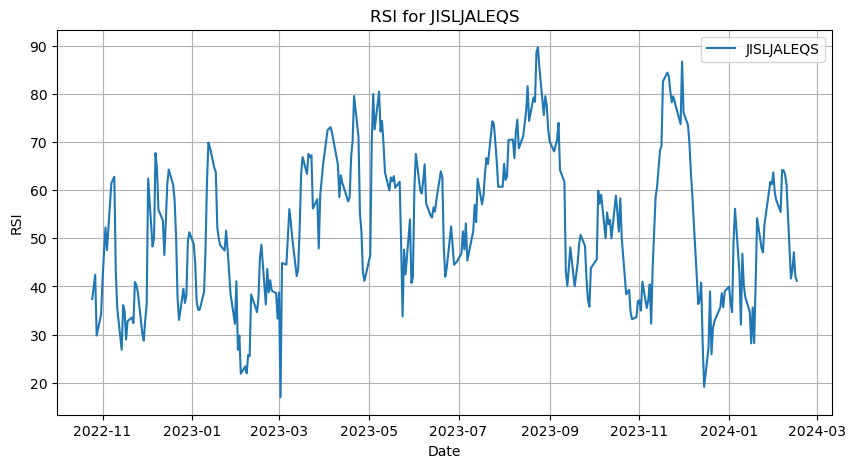

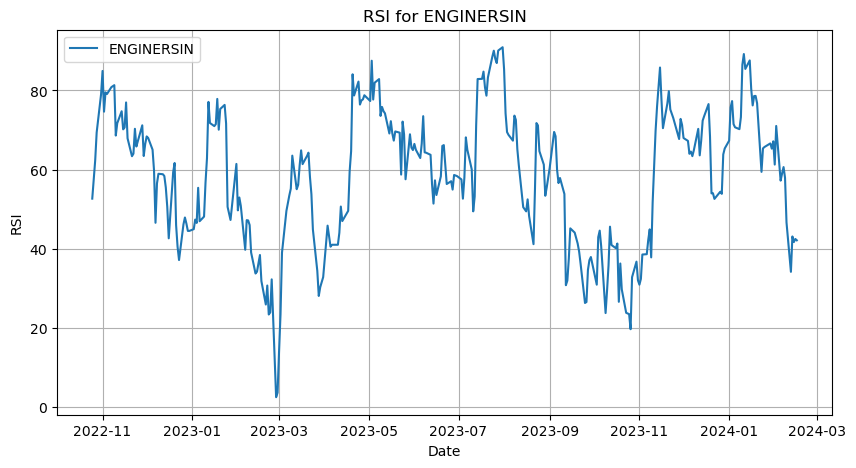

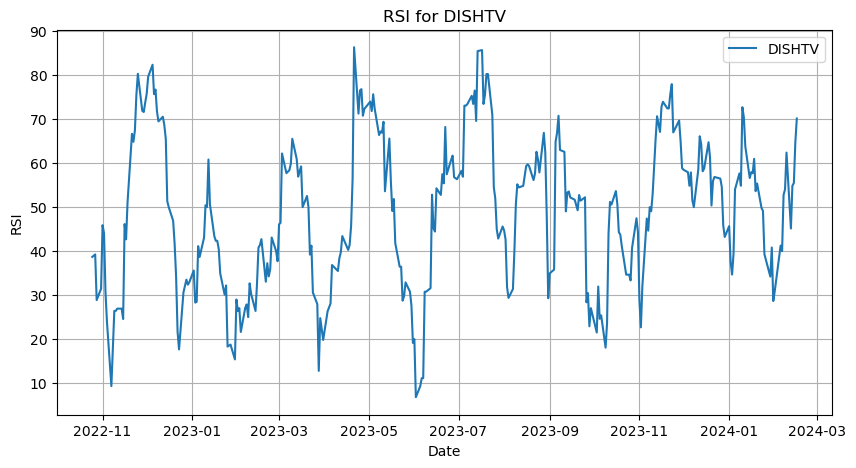

In [8]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt", "r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2], key_secret[3], TOTP(key_secret[4]).now())

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["token"]


def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["name"]


def hist_data(tickers, duration, interval, instrument_list, exchange="NSE"):
    hist_data_tickers = {}
    for ticker in tickers:
        params = {
            "exchange": exchange,
            "symboltoken": token_lookup(ticker, instrument_list),
            "interval": interval,
            "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
            "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')
        }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns=["date", "open", "high", "low", "close", "volume"])
        df_data.set_index("date", inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers


def calculate_rsi(data, window=14):
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Take user input for the stocks
stock_names = input("Enter stock names separated by commas: ").split(',')
stock_names = [s.strip().upper() for s in stock_names]  # Convert to uppercase and remove leading/trailing spaces

candle_data = hist_data(stock_names, 500, "ONE_DAY", instrument_list)

# Calculate RSI for each stock
rsi_data = {}
for ticker, data in candle_data.items():
    rsi_data[ticker] = calculate_rsi(data)

# Plot RSI for each stock
for ticker, rsi in rsi_data.items():
    plt.figure(figsize=(10, 5))
    plt.plot(rsi.index, rsi.values, label=ticker)
    plt.title(f"RSI for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
#RSI strategy graph with buy and sell signals for dynamically given stocks

[I 240218 03:25:17 smartConnect:113] in pool


Enter stock names separated by commas: IRFC,IRCTC,NHPC


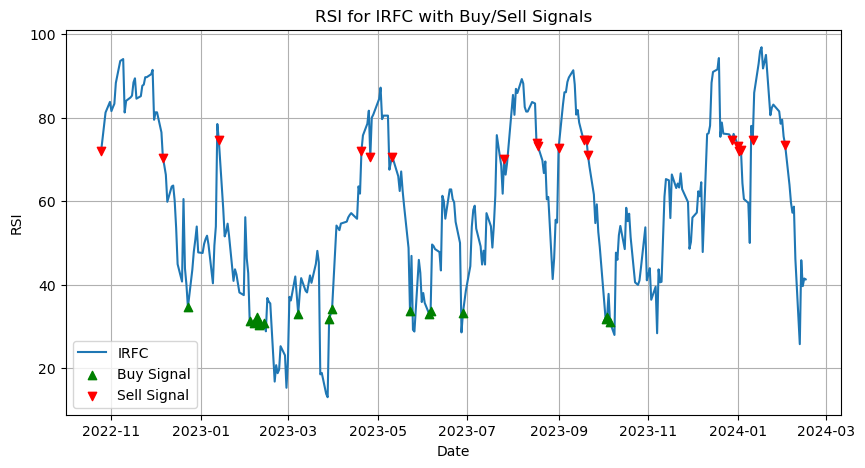

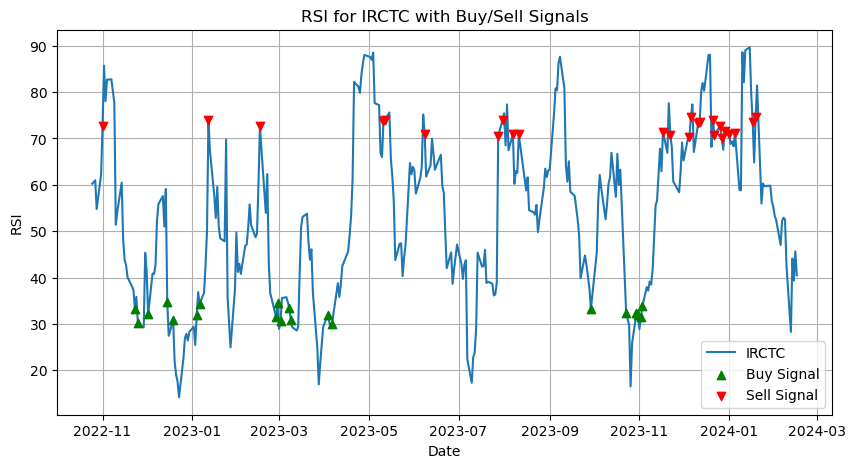

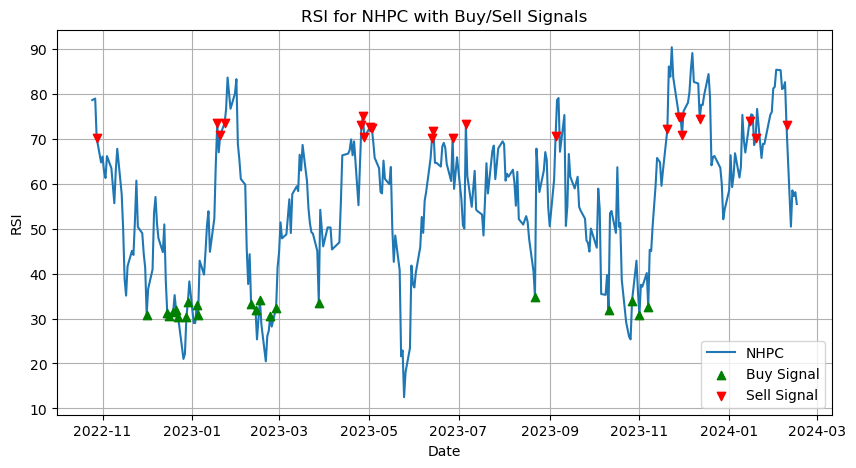

In [33]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt", "r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2], key_secret[3], TOTP(key_secret[4]).now())

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["token"]


def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["name"]


def hist_data(tickers, duration, interval, instrument_list, exchange="NSE"):
    hist_data_tickers = {}
    for ticker in tickers:
        params = {
            "exchange": exchange,
            "symboltoken": token_lookup(ticker, instrument_list),
            "interval": interval,
            "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
            "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')
        }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns=["date", "open", "high", "low", "close", "volume"])
        df_data.set_index("date", inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers


def calculate_rsi(data, window=14):
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Take user input for the stock names
stocks_input = input("Enter stock names separated by commas: ")
stock_names = [s.strip().upper() for s in stocks_input.split(',')]  # Convert to uppercase and remove leading/trailing spaces

candle_data = hist_data(stock_names, 500, "ONE_DAY", instrument_list)

# Calculate RSI for each stock
rsi_data = {}
for ticker, data in candle_data.items():
    rsi_data[ticker] = calculate_rsi(data)

# Plot RSI for each stock with buy and sell signals
for ticker, rsi in rsi_data.items():
    plt.figure(figsize=(10, 5))
    plt.plot(rsi.index, rsi.values, label=ticker)

    # Plot buy signals (RSI between 30-35)
    buy_signals = rsi[(rsi >= 30) & (rsi <= 35)]
    plt.scatter(buy_signals.index, buy_signals.values, marker='^', color='g', label='Buy Signal', zorder=5)

    # Plot sell signals (RSI between 70-75)
    sell_signals = rsi[(rsi >= 70) & (rsi <= 75)]
    plt.scatter(sell_signals.index, sell_signals.values, marker='v', color='r', label='Sell Signal', zorder=5)

    plt.title(f"RSI for {ticker} with Buy/Sell Signals")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.show()

[I 240218 06:52:37 smartConnect:113] in pool


Enter stock names separated by commas: IRCTC


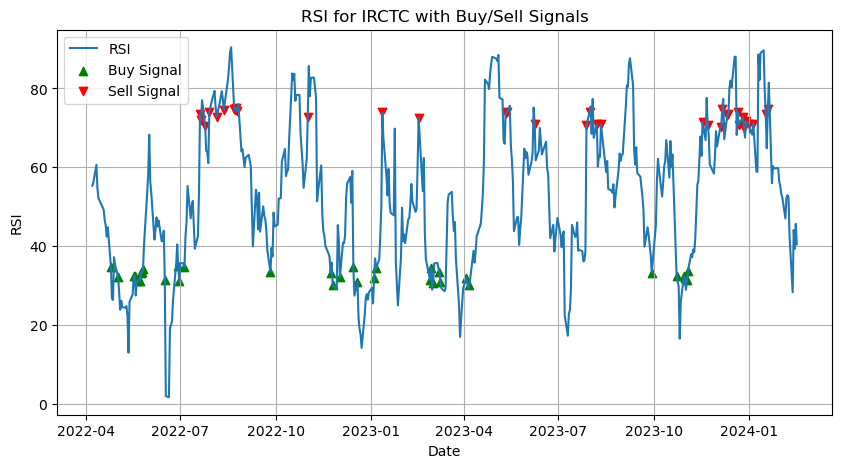

Cumulative return for IRCTC: 420.84%


In [2]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt", "r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2], key_secret[3], TOTP(key_secret[4]).now())

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["token"]


def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["name"]


def hist_data(tickers, duration, interval, instrument_list, exchange="NSE"):
    hist_data_tickers = {}
    for ticker in tickers:
        params = {
            "exchange": exchange,
            "symboltoken": token_lookup(ticker, instrument_list),
            "interval": interval,
            "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
            "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')
        }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns=["date", "open", "high", "low", "close", "volume"])
        df_data.set_index("date", inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers


def calculate_rsi(data, window=14):
    delta = data['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def calculate_cumulative_returns(df, buy_signals, sell_signals):
    cumulative_return = 0
    for i in range(len(buy_signals)):
        buy_price = df.loc[buy_signals.index[i], 'close']
        sell_price = df.loc[sell_signals.index[i], 'close']
        percentage_return = ((sell_price - buy_price) / buy_price) * 100
        cumulative_return += percentage_return
    return cumulative_return


# Take user input for the stock names
stocks_input = input("Enter stock names separated by commas: ")
stock_names = [s.strip().upper() for s in stocks_input.split(',')]  # Convert to uppercase and remove leading/trailing spaces

candle_data = hist_data(stock_names, 700, "ONE_DAY", instrument_list)

# Calculate RSI and cumulative returns for each stock
for ticker, df in candle_data.items():
    rsi = calculate_rsi(df)
    buy_signals = rsi[(rsi >= 30) & (rsi <= 35)]
    sell_signals = rsi[(rsi >= 70) & (rsi <= 75)]

    # Plot RSI with buy and sell signals
    plt.figure(figsize=(10, 5))
    plt.plot(rsi.index, rsi.values, label='RSI')
    plt.scatter(buy_signals.index, buy_signals.values, marker='^', color='g', label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals.values, marker='v', color='r', label='Sell Signal')
    plt.title(f"RSI for {ticker} with Buy/Sell Signals")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and display cumulative returns
    cumulative_return = calculate_cumulative_returns(df, buy_signals, sell_signals)
    print(f"Cumulative return for {ticker}: {cumulative_return:.2f}%")

In [3]:
#ORB Backtesting for smaller time period

top 5 gap stocks on 2022-06-22 00:00:00
Series([], dtype: object)
top 5 gap stocks on 2022-06-23 00:00:00
HEROMOTOCO    1.905366
dtype: float64
top 5 gap stocks on 2022-06-24 00:00:00
ICICIBANK     1.680612
POWERGRID     1.655904
ONGC          1.632047
HEROMOTOCO    1.529487
dtype: float64
top 5 gap stocks on 2022-06-27 00:00:00
HINDALCO     2.854483
ICICIBANK    2.158525
POWERGRID    2.105801
DRREDDY      2.092977
TATASTEEL    2.063548
dtype: float64
top 5 gap stocks on 2022-06-28 00:00:00
Series([], dtype: float64)
top 5 gap stocks on 2022-06-29 00:00:00
APOLLOHOSP    1.828084
WIPRO         1.696899
HCLTECH       1.681721
BAJFINANCE    1.636404
BPCL          1.569366
dtype: float64
top 5 gap stocks on 2022-06-30 00:00:00
BAJAJ-AUTO    3.039392
dtype: float64
top 5 gap stocks on 2022-07-01 00:00:00
TITAN        2.382486
ONGC         1.715605
BRITANNIA    1.569351
dtype: float64
top 5 gap stocks on 2022-07-04 00:00:00
JSWSTEEL    2.893668
dtype: float64
top 5 gap stocks on 2022-07-05 0

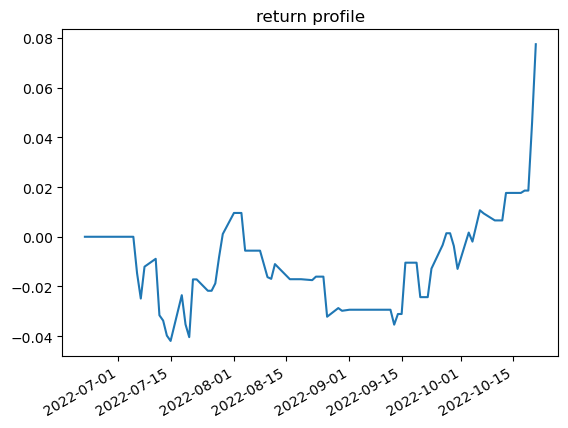

In [4]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
from statistics import mean
import threading
import urllib
import pandas as pd
import json

key_path=r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt","r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())
feed_token = obj.getfeedToken()
instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())

tickers = ["WIPRO","ULTRACEMCO","UPL","TITAN","TECHM","TATASTEEL","TATAMOTORS",
           "TATACONSUM","TCS","SUNPHARMA","SBIN","SBILIFE","RELIANCE","POWERGRID",
           "ONGC","NESTLEIND","NTPC","MARUTI","M&M","LT","KOTAKBANK","JSWSTEEL",
           "INFY","INDUSINDBK","ITC","ICICIBANK","HDFC","HINDUNILVR","HINDALCO",
           "HEROMOTOCO","HDFCLIFE","HDFCBANK","HCLTECH","GRASIM","EICHERMOT",
           "DRREDDY","DIVISLAB","COALINDIA","CIPLA","BRITANNIA","BHARTIARTL",
           "BPCL","BAJAJFINSV","BAJFINANCE","BAJAJ-AUTO","AXISBANK","ASIANPAINT",
           "APOLLOHOSP","ADANIPORTS","ADANIENT"]
bktst_start_dt = "2022-06-21 09:15"
bktst_end_dt = "2022-10-21 15:30"

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["name"]

def hist_data_daily(tickers,instrument_list,exchange="NSE"):
    hist_data_tickers = {} 
    for ticker in tickers:
        time.sleep(0.3)
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker,instrument_list),
                 "interval": "ONE_DAY",
                 "fromdate": bktst_start_dt,
                 "todate": bktst_end_dt 
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date",inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        df_data["gap"] = ((df_data["open"]/df_data["close"].shift(1))-1)*100
        df_data["avvol"] = df_data["volume"].rolling(10).mean().shift(1)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers

def hist_data_intraday(ticker,datestamp,interval,instrument_list,exchange="NSE"):
    params = {
             "exchange": exchange,
             "symboltoken": token_lookup(ticker,instrument_list),
             "interval": interval,
             "fromdate": datestamp.strftime("%Y-%m-%d")+ " 09:15",
             "todate": datestamp.strftime("%Y-%m-%d") + " 15:30" 
             }
    hist_data = obj.getCandleData(params)
    df_data = pd.DataFrame(hist_data["data"],
                           columns = ["date","open","high","low","close","volume"])
    df_data.set_index("date",inplace=True)
    df_data.index = pd.to_datetime(df_data.index)
    df_data.index = df_data.index.tz_localize(None)
    return df_data

candle_data = hist_data_daily(tickers, instrument_list)


def topGap(data):
    top_gap_by_date = {}
    dates = data[tickers[0]].index.to_list()    
    for date in dates:
        temp = pd.Series()
        for ticker in data:
            try:
                temp.loc[ticker] = data[ticker].loc[date,"gap"]
            except:
                pass
        top_gap_by_date[date] = (abs(temp[abs(temp)>1.5])).sort_values(ascending=False)[:5].index.to_list()
        print("top 5 gap stocks on {}".format(date))
        print((abs(temp[abs(temp)>1.5])).sort_values(ascending=False)[:5])
    
    return top_gap_by_date

top_gap_by_date = topGap(candle_data)


def backtest(top_gap_by_date, candle_data):
    date_stats = {}
    for date in top_gap_by_date:
        date_orgnl = date.strftime("%Y-%m-%d %H:%M")
        date_stats[date] = {}
        for ticker in top_gap_by_date[date]:
            try:
                intraday_df = hist_data_intraday(ticker,date,'FIVE_MINUTE',instrument_list)
                hi_price = intraday_df.iloc[0]['high']
                lo_price = intraday_df.iloc[0]['low']
                open_price = ''
                direction = ''
                date_stats[date][ticker] = 0
                for i in range(1,len(intraday_df[1:])):
                    if intraday_df.iloc[i]["volume"] > 2*(candle_data[ticker].loc[date_orgnl,"avvol"])/75 \
                       and intraday_df.iloc[i]["high"] > hi_price \
                       and open_price == '':
                        open_price = 0.8*intraday_df.iloc[i+1]["open"] + 0.2*intraday_df.iloc[i+1]["high"] #factoring in slippage
                        direction = 'long'
                    elif intraday_df.iloc[i]["volume"] > 2*(candle_data[ticker].loc[date_orgnl,"avvol"])/75 \
                       and intraday_df.iloc[i]["low"] < lo_price \
                       and open_price == '':
                        open_price = 0.8*intraday_df.iloc[i+1]["open"] + 0.2*intraday_df.iloc[i+1]["low"] #factoring in slippage
                        direction = 'short'
                        
                    if open_price != '' and direction == 'long':
                        if intraday_df.iloc[i]["high"] > hi_price*1.05:
                            ticker_return = ((hi_price*1.05)/open_price)-1
                            date_stats[date][ticker] = ticker_return
                            break
                        elif intraday_df.iloc[i]["low"] < lo_price:
                            ticker_return = (lo_price/open_price) - 1
                            date_stats[date][ticker] = ticker_return
                            break
                        else:
                            ticker_return = (intraday_df.iloc[i]["close"]/open_price) - 1
                            date_stats[date][ticker] = ticker_return
                            
                    if open_price != '' and direction == 'short':
                        if intraday_df.iloc[i]["low"] < lo_price*0.95:
                            ticker_return = 1 - ((lo_price*0.95)/open_price)
                            date_stats[date][ticker] = ticker_return
                            break
                        elif intraday_df.iloc[i]["high"] > hi_price:
                            ticker_return = 1 - (hi_price/open_price)
                            date_stats[date][ticker] = ticker_return
                            break
                        else:
                            ticker_return = 1 - (intraday_df.iloc[i]["close"]/open_price)
                            date_stats[date][ticker] = ticker_return
            except:
                print(ticker,date)
                                                 
    return date_stats
                    
date_stats = backtest(top_gap_by_date, candle_data)

###########################KPIs#####################################

def abs_return(date_stats):
    df = pd.DataFrame(date_stats).T
    df["ret"] = df.mean(axis=1)
    df["ret"].fillna(0,inplace=True)
    return (1+df["ret"]).cumprod().iloc[-1] - 1

def win_rate(date_stats):
    win_count = 0
    lose_count = 0
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] > 0:
                win_count+=1
            elif date_stats[i][ticker] < 0:
                lose_count+=1
    return (win_count/(win_count+lose_count))*100
    
def mean_ret_winner(date_stats):
    win_ret = []
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] > 0:
                win_ret.append(date_stats[i][ticker])
    return sum(win_ret)/len(win_ret)

def mean_ret_loser(date_stats):
    los_ret = []
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] < 0:
                los_ret.append(date_stats[i][ticker])
    return sum(los_ret)/len(los_ret)

def equity_curve(date_stats):
    df = pd.DataFrame(date_stats).T
    df["ret"] = df.mean(axis=1)
    df["ret"].fillna(0,inplace=True)
    df["cum_ret"] = (1+df["ret"]).cumprod() - 1
    df["cum_ret"].plot(title="return profile")
    
print("****************Strategy Performance Statistics***************")
print("total cumulative return = {}".format(round(abs_return(date_stats),4)))
print("total win rate = {}".format(round(win_rate(date_stats),2)))
print("mean return per win trade = {}".format(round(mean_ret_winner(date_stats),4)))
print("mean return per loss trade = {}".format(round(mean_ret_loser(date_stats),4)))
equity_curve(date_stats)

In [2]:
#ORB Backtesting KPI

[I 240217 23:46:06 smartConnect:113] in pool


top 5 gap stocks on 2021-09-22 00:00:00
Series([], dtype: object)
top 5 gap stocks on 2021-09-23 00:00:00
SBILIFE      2.744901
HINDALCO     2.267819
TATASTEEL    1.853270
dtype: float64
top 5 gap stocks on 2021-09-24 00:00:00
Series([], dtype: float64)
top 5 gap stocks on 2021-09-27 00:00:00
TATAMOTORS    1.635477
dtype: float64
top 5 gap stocks on 2021-09-28 00:00:00
ADANIENT    1.681633
dtype: float64
top 5 gap stocks on 2021-09-29 00:00:00
INFY     1.650762
WIPRO    1.508755
dtype: float64
top 5 gap stocks on 2021-09-30 00:00:00
Series([], dtype: float64)
top 5 gap stocks on 2021-10-01 00:00:00
MARUTI    1.608738
dtype: float64
top 5 gap stocks on 2021-10-04 00:00:00
NTPC         2.537527
COALINDIA    2.013778
dtype: float64
top 5 gap stocks on 2021-10-05 00:00:00
HINDALCO    1.918133
ONGC        1.626016
dtype: float64
top 5 gap stocks on 2021-10-06 00:00:00
Series([], dtype: float64)
top 5 gap stocks on 2021-10-07 00:00:00
TITAN         4.998487
HINDALCO      1.912166
POWERGRID  

dtype: float64
top 5 gap stocks on 2022-05-10 00:00:00
ONGC          2.610015
HINDALCO      2.049088
UPL           1.851852
ASIANPAINT    1.522336
dtype: float64
top 5 gap stocks on 2022-05-11 00:00:00
CIPLA    1.52783
dtype: float64
top 5 gap stocks on 2022-05-12 00:00:00
MARUTI        2.365324
HDFCBANK      2.039152
TATAMOTORS    1.584439
HINDALCO      1.550112
dtype: float64
top 5 gap stocks on 2022-05-13 00:00:00
TATAMOTORS    3.948429
ONGC          2.236422
BAJAJFINSV    2.165641
DIVISLAB      1.927529
ADANIENT      1.921572
dtype: float64
top 5 gap stocks on 2022-05-16 00:00:00
EICHERMOT     3.586624
JSWSTEEL      2.589724
HINDALCO      2.010309
TATASTEEL     2.005469
TATAMOTORS    1.879792
dtype: float64
top 5 gap stocks on 2022-05-17 00:00:00
HINDALCO     2.059087
TATASTEEL    1.857725
TITAN        1.678043
ONGC         1.628664
dtype: float64
top 5 gap stocks on 2022-05-18 00:00:00
BHARTIARTL    1.972986
BPCL          1.752081
dtype: float64
top 5 gap stocks on 2022-05-19 00:0

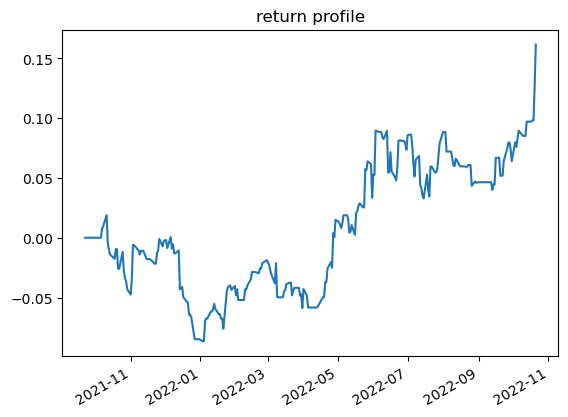

In [3]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json
import time
import numpy as np
import matplotlib.pyplot as plt

key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt", "r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2], key_secret[3], TOTP(key_secret[4]).now())

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


tickers = ["WIPRO","ULTRACEMCO","UPL","TITAN","TECHM","TATASTEEL","TATAMOTORS",
           "TATACONSUM","TCS","SUNPHARMA","SBIN","SBILIFE","RELIANCE","POWERGRID",
           "ONGC","NESTLEIND","NTPC","MARUTI","M&M","LT","KOTAKBANK","JSWSTEEL",
           "INFY","INDUSINDBK","ITC","ICICIBANK","HDFC","HINDUNILVR","HINDALCO",
           "HEROMOTOCO","HDFCLIFE","HDFCBANK","HCLTECH","GRASIM","EICHERMOT",
           "DRREDDY","DIVISLAB","COALINDIA","CIPLA","BRITANNIA","BHARTIARTL",
           "BPCL","BAJAJFINSV","BAJFINANCE","BAJAJ-AUTO","AXISBANK","ASIANPAINT",
           "APOLLOHOSP","ADANIPORTS","ADANIENT"]
bktst_start_dt = "2021-09-21 09:15"
bktst_end_dt = "2022-10-21 15:30"

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["name"]

def hist_data_daily(tickers,instrument_list,exchange="NSE"):
    hist_data_tickers = {} 
    for ticker in tickers:
        time.sleep(0.3)
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker,instrument_list),
                 "interval": "ONE_DAY",
                 "fromdate": bktst_start_dt,
                 "todate": bktst_end_dt 
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date",inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        df_data["gap"] = ((df_data["open"]/df_data["close"].shift(1))-1)*100
        df_data["avvol"] = df_data["volume"].rolling(10).mean().shift(1)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers

def hist_data_intraday(ticker,datestamp,interval,instrument_list,exchange="NSE"):
    params = {
             "exchange": exchange,
             "symboltoken": token_lookup(ticker,instrument_list),
             "interval": interval,
             "fromdate": datestamp.strftime("%Y-%m-%d")+ " 09:15",
             "todate": datestamp.strftime("%Y-%m-%d") + " 15:30" 
             }
    hist_data = obj.getCandleData(params)
    df_data = pd.DataFrame(hist_data["data"],
                           columns = ["date","open","high","low","close","volume"])
    df_data.set_index("date",inplace=True)
    df_data.index = pd.to_datetime(df_data.index)
    df_data.index = df_data.index.tz_localize(None)
    return df_data

candle_data = hist_data_daily(tickers, instrument_list)


def topGap(data):
    top_gap_by_date = {}
    dates = data[tickers[0]].index.to_list()    
    for date in dates:
        temp = pd.Series()
        for ticker in data:
            try:
                temp.loc[ticker] = data[ticker].loc[date,"gap"]
            except:
                pass
        top_gap_by_date[date] = (abs(temp[abs(temp)>1.5])).sort_values(ascending=False)[:5].index.to_list()
        print("top 5 gap stocks on {}".format(date))
        print((abs(temp[abs(temp)>1.5])).sort_values(ascending=False)[:5])
    
    return top_gap_by_date

top_gap_by_date = topGap(candle_data)


def backtest(top_gap_by_date, candle_data):
    date_stats = {}
    for date in top_gap_by_date:
        date_orgnl = date.strftime("%Y-%m-%d %H:%M")
        date_stats[date] = {}
        for ticker in top_gap_by_date[date]:
            try:
                intraday_df = hist_data_intraday(ticker,date,'FIVE_MINUTE',instrument_list)
                hi_price = intraday_df.iloc[0]['high']
                lo_price = intraday_df.iloc[0]['low']
                open_price = ''
                direction = ''
                date_stats[date][ticker] = 0
                for i in range(1,len(intraday_df[1:])):
                    if intraday_df.iloc[i]["volume"] > 2*(candle_data[ticker].loc[date_orgnl,"avvol"])/75 \
                       and intraday_df.iloc[i]["high"] > hi_price \
                       and open_price == '':
                        open_price = 0.8*intraday_df.iloc[i+1]["open"] + 0.2*intraday_df.iloc[i+1]["high"] #factoring in slippage
                        direction = 'long'
                    elif intraday_df.iloc[i]["volume"] > 2*(candle_data[ticker].loc[date_orgnl,"avvol"])/75 \
                       and intraday_df.iloc[i]["low"] < lo_price \
                       and open_price == '':
                        open_price = 0.8*intraday_df.iloc[i+1]["open"] + 0.2*intraday_df.iloc[i+1]["low"] #factoring in slippage
                        direction = 'short'
                        
                    if open_price != '' and direction == 'long':
                        if intraday_df.iloc[i]["high"] > hi_price*1.05:
                            ticker_return = ((hi_price*1.05)/open_price)-1
                            date_stats[date][ticker] = ticker_return
                            break
                        elif intraday_df.iloc[i]["low"] < lo_price:
                            ticker_return = (lo_price/open_price) - 1
                            date_stats[date][ticker] = ticker_return
                            break
                        else:
                            ticker_return = (intraday_df.iloc[i]["close"]/open_price) - 1
                            date_stats[date][ticker] = ticker_return
                            
                    if open_price != '' and direction == 'short':
                        if intraday_df.iloc[i]["low"] < lo_price*0.95:
                            ticker_return = 1 - ((lo_price*0.95)/open_price)
                            date_stats[date][ticker] = ticker_return
                            break
                        elif intraday_df.iloc[i]["high"] > hi_price:
                            ticker_return = 1 - (hi_price/open_price)
                            date_stats[date][ticker] = ticker_return
                            break
                        else:
                            ticker_return = 1 - (intraday_df.iloc[i]["close"]/open_price)
                            date_stats[date][ticker] = ticker_return
            except:
                print(ticker,date)
                                                 
    return date_stats
                    
date_stats = backtest(top_gap_by_date, candle_data)


###########################KPIs#####################################
def abs_return(date_stats):
    df = pd.DataFrame(date_stats).T
    df["ret"] = 1+df.mean(axis=1)
    cum_ret = (df["ret"].cumprod() - 1)[-1]
    return  cum_ret

def win_rate(date_stats):
    win_count = 0
    lose_count = 0
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] > 0:
                win_count+=1
            elif date_stats[i][ticker] < 0:
                lose_count+=1
    return (win_count/(win_count+lose_count))*100

def mean_ret_winner(date_stats):
    win_ret = []
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] > 0:
                win_ret.append(date_stats[i][ticker])                
    return sum(win_ret)/len(win_ret)

def mean_ret_loser(date_stats):
    los_ret = []
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] < 0:
                los_ret.append(date_stats[i][ticker])                
    return sum(los_ret)/len(los_ret)

def return_curve(date_stats):
    df = pd.DataFrame(date_stats).T
    df["ret"] = 1+df.mean(axis=1)
    df["ret"] = df["ret"].fillna(1)
    df["cum_ret"] = (df["ret"].cumprod() - 1)
    df["cum_ret"].plot(title="return profile")


print("**********Strategy Performance Statistics**********")
print("total cumulative return = {}".format(round(abs_return(date_stats),4)))
print("total win rate = {}".format(round(win_rate(date_stats),2)))
print("mean return per win trade = {}".format(round(mean_ret_winner(date_stats),4)))
print("mean return per loss trade = {}".format(round(mean_ret_loser(date_stats),4)))
return_curve(date_stats)

In [4]:
#Order in AngelOne

In [11]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import urllib
import json
from pyotp import TOTP

key_path = r"C:\Users\sarda\Desktop"
os.chdir(key_path)

key_secret = open("secret.txt","r").read().split()

obj=SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())
feed_token = obj.getfeedToken()

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]

def place_limit_order(instrument_list,ticker,buy_sell,price,quantity,exchange="NSE"):
    params = {
                "variety":"NORMAL",
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken":token_lookup(ticker, instrument_list),
                "transactiontype":buy_sell,
                "exchange":exchange,
                "ordertype":"LIMIT",
                "producttype":"DELIVERY",
                "duration":"DAY",
                "price":price,
                "quantity":quantity
                }
    response = obj.placeOrder(params)
    return response

def place_market_order(instrument_list,ticker,buy_sell,quantity,exchange="NSE"):
    params = {
                "variety":"NORMAL",
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken":token_lookup(ticker, instrument_list),
                "transactiontype":buy_sell,
                "exchange":exchange,
                "ordertype":"MARKET",
                "producttype":"INTRADAY",
                "duration":"DAY",
                "quantity":quantity
                }
    response = obj.placeOrder(params)
    return response

def cancel_order(order_id):
    params = {
              "variety":"NORMAL",
              "orderid":order_id
             }
    response = obj.cancelOrder(params["orderid"], params["variety"])
    return response


order_id = place_limit_order(instrument_list, "HCLTECH", "BUY", 880, 2)

def get_open_orders():
    response = obj.orderBook()
    df = pd.DataFrame(response['data'])
    return df[df["orderstatus"]=="open"]

def place_sl_limit_order(instrument_list,ticker,buy_sell,price,quantity,exchange="NSE"):
    params = {
                "variety":"STOPLOSS",
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken":token_lookup(ticker, instrument_list),
                "transactiontype":buy_sell,
                "exchange":exchange,
                "ordertype":"STOPLOSS_LIMIT",
                "producttype":"INTRADAY",
                "duration":"DAY",
                "price":price+0.05,
                "triggerprice":price,
                "quantity":quantity
                }
    response = obj.placeOrder(params)
    return response

def place_sl_market_order(instrument_list,ticker,buy_sell,price,quantity,sl=0,sqof=0,exchange="NSE"):
    params = {
                "variety":"STOPLOSS",
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken":token_lookup(ticker, instrument_list),
                "transactiontype":buy_sell,
                "exchange":exchange,
                "ordertype":"STOPLOSS_MARKET",
                "producttype":"INTRADAY",
                "duration":"DAY",
                "triggerprice":price,
                "price":price,
                "quantity":quantity
                }
    response = obj.placeOrder(params)
    return response

def place_gtt_order(instrument_list,ticker,buy_sell,price,quantity,exchange="NSE"):
    params = {
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken":token_lookup(ticker, instrument_list),
                "transactiontype":buy_sell,
                "exchange":exchange,
                "producttype":"DELIVERY",
                "price":price+1,
                "triggerprice": price,
                "qty":quantity,
                "timeperiod": "20"
                }
    response = obj.gttCreateRule(params)
    return response

rule_id = place_gtt_order(instrument_list,"HCLTECH","BUY",500,10)

def modify_gtt_order(rule_id,instrument_list,ticker,price,quantity,exchange="NSE"):
    params = {
                 "id": rule_id,
                 "symboltoken": token_lookup(ticker, instrument_list),
                 "exchange": exchange,
                 "price": price+1,
                 "qty": quantity,
                 "triggerprice": price,
            }
    response = obj.gttModifyRule(params)
    return response

def cancel_gtt_order(rule_id,instrument_list,ticker,exchange="NSE"):
    params = {
                 "id": rule_id,
                 "symboltoken": token_lookup(ticker, instrument_list),
                 "exchange": exchange
            }
    response = obj.gttCancelRule(params)
    return response
place_limit_order(instrument_list, "HDFC", "BUY", 2400, 1)
place_market_order(instrument_list,"ADANIENT","SELL",250)
modify_gtt_order(rule_id, instrument_list, "HCLTECH", 550, 5)
cancel_gtt_order(rule_id, instrument_list,"HCLTECH")

[I 240217 21:21:19 smartConnect:113] in pool


{'status': True,
 'message': 'SUCCESS',
 'errorcode': '',
 'data': {'id': 2348477}}

In [5]:
#Live testing OrderBook strategy

In [12]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
from statistics import mean
import threading
import urllib
import pandas as pd
import json

key_path=r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt","r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())
feed_token = obj.getfeedToken()
instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


tickers = ["WIPRO","ULTRACEMCO","UPL","TITAN","TECHM","TATASTEEL","TATAMOTORS",
           "TATACONSUM","TCS","SUNPHARMA","SBIN","SBILIFE","RELIANCE","POWERGRID",
           "ONGC","NESTLEIND","NTPC","MARUTI","M&M","LT","KOTAKBANK","JSWSTEEL",
           "INFY","INDUSINDBK","ITC","ICICIBANK","HDFC","HINDUNILVR","HINDALCO",
           "HEROMOTOCO","HDFCLIFE","HDFCBANK","HCLTECH","GRASIM","EICHERMOT",
           "DRREDDY","DIVISLAB","COALINDIA","CIPLA","BRITANNIA","BHARTIARTL",
           "BPCL","BAJAJFINSV","BAJFINANCE","BAJAJ-AUTO","AXISBANK","ASIANPAINT",
           "APOLLOHOSP","ADANIPORTS","ADANIENT"]


bid_ask_ratio = {}
long_trades = {}
short_trades = {}
for ticker in tickers:
    bid_ask_ratio[ticker] = []
    long_trades[ticker] = []
    short_trades[ticker] = []
pos_size = 10000

long_pos = []
short_pos = []

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token,exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange:
            return instrument["symbol"][:-3]

def stream_list(list_stocks,exchange="nse_cm"):
    #SAMPLE: nse_cm|2885&nse_cm|1594&nse_cm|11536&nse_cm|3045
    # token="mcx_fo|226745&mcx_fo|220822&mcx_fo|227182&mcx_fo|221599"
    return_string = ''
    for count,ticker in enumerate(list_stocks):
        if count != 0:
            return_string+= '&'+exchange+'|'+token_lookup(ticker,instrument_list)
        else:
            return_string+= exchange+'|'+token_lookup(ticker,instrument_list)
    return return_string

def expected_buy_price(tick, pos_size):
    ask_prices = [float(tick[i]) for i in tick if i[:2]=="sp"]
    ask_sizes = [float(tick[i]) for i in tick if i[:2]=="bs"]
   
    cum_pos = 0
    cum_size = 0
    prev_fill = 0
    prev_price = 0
    
    for i in range(len(ask_prices)):
        cum_pos+= ask_prices[i]*ask_sizes[i]
        cum_size+= ask_sizes[i]
        if pos_size <= cum_pos:
            return ((prev_price*prev_fill) + (ask_prices[i]*(pos_size - prev_fill)))/pos_size
        else:
            prev_fill = cum_pos
            prev_price = round(cum_pos/cum_size,2)
    return round(cum_pos/cum_size,2)
        
def expected_sell_price(tick, pos_size):
    bid_prices = [float(tick[i]) for i in tick if i[:2]=="bp"]
    bid_sizes = [float(tick[i]) for i in tick if i[:2]=="bq"]
    
    cum_pos = 0
    cum_size = 0
    prev_fill = 0
    prev_price = 0
    
    for i in range(len(bid_prices)):
        cum_pos+= bid_prices[i]*bid_sizes[i]
        cum_size+= bid_sizes[i]
        if pos_size <= cum_pos:
            return ((prev_price*prev_fill) + (bid_prices[i]*(pos_size - prev_fill)))/pos_size
        else:
            prev_fill = cum_pos
            prev_price = round(cum_pos/cum_size,2)
    return round(cum_pos/cum_size,2)
    
            
def trend_detection(ratio_list):
    if len(ratio_list) >= 30 and max(ratio_list) >= 10 and min(ratio_list) >= 5 and mean(ratio_list) >= 8:
        return "Buy"
    elif len(ratio_list) >= 30 and min(ratio_list) <= 0.1 and max(ratio_list) <= 0.2 and mean(ratio_list) <= 0.125 :
        return "Sell"
    else:
        return 0
    
def exit_long(ratio_list):
    if max(ratio_list) <= 4 and min(ratio_list) <= 1.5 and mean(ratio_list) <= 2:
        return True
    else:
        return False
    
def exit_short(ratio_list):
    if min(ratio_list) >= 0.25 and max(ratio_list) >= 0.65 and mean(ratio_list) >= 0.4:
        return True
    else:
        return False
    
def market_pressure(tick):
    token = tick['token']
    tot_bid_vol = 0
    tot_ask_vol = 0
    buy_data = tick['best_5_buy_data']
    sell_data = tick['best_5_sell_data']
    for bd in buy_data:
        tot_bid_vol+= int(bd['quantity'])
    for sd in sell_data:
        tot_ask_vol+= int(sd['quantity'])

    bid_ask_ratio[symbol_lookup(token)].append(tot_bid_vol/tot_ask_vol)
    if len(bid_ask_ratio[symbol_lookup(token)]) > 30:
        bid_ask_ratio[symbol_lookup(token)].pop(0)
    
    if symbol_lookup(token) not in long_pos:
        if trend_detection(bid_ask_ratio[symbol_lookup(token)]) == "Buy":
            print("{}: buy {} at price {} : total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_buy_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            long_pos.append(symbol_lookup(token))
            long_trades[symbol_lookup(token)].append([expected_buy_price(tick,pos_size)])
    else:
        if exit_long(bid_ask_ratio[symbol_lookup(token)]):
            print("{}: close long {} at price {} : total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_sell_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            long_pos.remove(symbol_lookup(token))
            long_trades[symbol_lookup(token)][-1].append(expected_sell_price(tick,pos_size))
    if symbol_lookup(token) not in short_pos:
        if trend_detection(bid_ask_ratio[symbol_lookup(token)]) == "Sell":    
            print("{}: sell {} at price {}: total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_sell_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            short_pos.append(symbol_lookup(token))
            short_trades[symbol_lookup(token)].append([expected_sell_price(tick,pos_size)])
    else:
        if exit_short(bid_ask_ratio[symbol_lookup(token)]):
            print("{}: close short {} at price {} : total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_buy_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            short_pos.remove(symbol_lookup(token))
            short_trades[symbol_lookup(token)][-1].append(expected_buy_price(tick,pos_size))

    print(symbol_lookup(token), "last 5 bid ask ratios :", bid_ask_ratio[symbol_lookup(token)][-5:])


sws = SmartWebSocketV2(data["data"]["jwtToken"], key_secret[0], key_secret[2], feed_token)


correlation_id = "stream_1" #any string value which will help identify the specific streaming in case of concurrent streaming
action = 1 #1 subscribe, 0 unsubscribe
mode = 3 #1 for LTP, 2 for Quote and 2 for SnapQuote
token_list = [{"exchangeType": 1, "tokens": [token_lookup(i,instrument_list) for i in tickers]}]


def on_data(ws, message):
    market_pressure(message)
    
def on_open(ws):
    print("on open")
    sws.subscribe(correlation_id, mode, token_list)
    
def on_error(ws, error):
    print(error)
    

def connect():
    # Assign the callbacks.
    sws.on_open = on_open
    sws.on_data = on_data
    sws.on_error = on_error

    sws.connect()
    
con_thread = threading.Thread(target=connect)
con_thread.start()

[I 240217 21:24:01 smartConnect:113] in pool


on open
BAJAJFINSV last 5 bid ask ratios : [0.0]
APOLLOHOSP last 5 bid ask ratios : [0.0]
HDFCBANK last 5 bid ask ratios : [0.0]
ASIANPAINT last 5 bid ask ratios : [0.0]
INDUSINDBK last 5 bid ask ratios : [0.0]
BAJFINANCE last 5 bid ask ratios : [0.0]
ICICIBANK last 5 bid ask ratios : [0.0]
NESTLEIND last 5 bid ask ratios : [0.0]
INFY last 5 bid ask ratios : [0.0]
DRREDDY last 5 bid ask ratios : [0.0]
TECHM last 5 bid ask ratios : [0.0]
ONGC last 5 bid ask ratios : [0.0]
NTPC last 5 bid ask ratios : [0.0]
AXISBANK last 5 bid ask ratios : [0.0]
LT last 5 bid ask ratios : [0.0]
JSWSTEEL last 5 bid ask ratios : [0.0]
CIPLA last 5 bid ask ratios : [0.0]
MARUTI last 5 bid ask ratios : [0.0]
SUNPHARMA last 5 bid ask ratios : [0.0]
TCS last 5 bid ask ratios : [0.0]
HDFCLIFE last 5 bid ask ratios : [0.0]
BRITANNIA last 5 bid ask ratios : [0.0]
WIPRO last 5 bid ask ratios : [0.0]
HCLTECH last 5 bid ask ratios : [0.0]
TITAN last 5 bid ask ratios : [0.0]
KOTAKBANK last 5 bid ask ratios : [0.0]


In [1]:
#KPI live testing strategy

In [2]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
from statistics import mean
import threading
import urllib
import time
import pandas as pd
import json

key_path=r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt","r").read().split()

obj=SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())
feed_token = obj.getfeedToken()

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())


tickers = ["WIPRO","ULTRACEMCO","UPL","TITAN","TECHM","TATASTEEL","TATAMOTORS",
           "TATACONSUM","TCS","SUNPHARMA","SBIN","SBILIFE","RELIANCE","POWERGRID",
           "ONGC","NESTLEIND","NTPC","MARUTI","M&M","LT","KOTAKBANK","JSWSTEEL",
           "INFY","INDUSINDBK","ITC","ICICIBANK","HDFC","HINDUNILVR","HINDALCO",
           "HEROMOTOCO","HDFCLIFE","HDFCBANK","HCLTECH","GRASIM","EICHERMOT",
           "DRREDDY","DIVISLAB","COALINDIA","CIPLA","BRITANNIA","BHARTIARTL",
           "BPCL","BAJAJFINSV","BAJFINANCE","BAJAJ-AUTO","AXISBANK","ASIANPAINT",
           "APOLLOHOSP","ADANIPORTS","ADANIENT"]


bid_ask_ratio = {}
long_trades = {}
short_trades = {}
for ticker in tickers:
    bid_ask_ratio[ticker] = []
    long_trades[ticker] = []
    short_trades[ticker] = []
pos_size = 10000

long_pos = []
short_pos = []

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token,exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange:
            return instrument["symbol"][:-3]

def stream_list(list_stocks,exchange="nse_cm"):
    #SAMPLE: nse_cm|2885&nse_cm|1594&nse_cm|11536&nse_cm|3045
    # token="mcx_fo|226745&mcx_fo|220822&mcx_fo|227182&mcx_fo|221599"
    return_string = ''
    for count,ticker in enumerate(list_stocks):
        if count != 0:
            return_string+= '&'+exchange+'|'+token_lookup(ticker,instrument_list)
        else:
            return_string+= exchange+'|'+token_lookup(ticker,instrument_list)
    return return_string

def expected_buy_price(tick, pos_size):
    ask_prices = [float(tick[i]) for i in tick if i[:2]=="sp"]
    ask_sizes = [float(tick[i]) for i in tick if i[:2]=="bs"]
   
    cum_pos = 0
    cum_size = 0
    prev_fill = 0
    prev_price = 0
    
    for i in range(len(ask_prices)):
        cum_pos+= ask_prices[i]*ask_sizes[i]
        cum_size+= ask_sizes[i]
        if pos_size <= cum_pos:
            return ((prev_price*prev_fill) + (ask_prices[i]*(pos_size - prev_fill)))/pos_size
        else:
            prev_fill = cum_pos
            prev_price = round(cum_pos/cum_size,2)
    return round(cum_pos/cum_size,2)
        
def expected_sell_price(tick, pos_size):
    bid_prices = [float(tick[i]) for i in tick if i[:2]=="bp"]
    bid_sizes = [float(tick[i]) for i in tick if i[:2]=="bq"]
    
    cum_pos = 0
    cum_size = 0
    prev_fill = 0
    prev_price = 0
    
    for i in range(len(bid_prices)):
        cum_pos+= bid_prices[i]*bid_sizes[i]
        cum_size+= bid_sizes[i]
        if pos_size <= cum_pos:
            return ((prev_price*prev_fill) + (bid_prices[i]*(pos_size - prev_fill)))/pos_size
        else:
            prev_fill = cum_pos
            prev_price = round(cum_pos/cum_size,2)
    return round(cum_pos/cum_size,2)
    
            
def trend_detection(ratio_list):
    if len(ratio_list) >= 30 and max(ratio_list) >= 10 and min(ratio_list) >= 5 and mean(ratio_list) >= 8:
        return "Buy"
    elif len(ratio_list) >= 30 and min(ratio_list) <= 0.1 and max(ratio_list) <= 0.2 and mean(ratio_list) <= 0.125 :
        return "Sell"
    else:
        return 0
    
def exit_long(ratio_list):
    if max(ratio_list) <= 4 and min(ratio_list) <= 1.5 and mean(ratio_list) <= 2:
        return True
    else:
        return False
    
def exit_short(ratio_list):
    if min(ratio_list) >= 0.25 and max(ratio_list) >= 0.65 and mean(ratio_list) >= 0.4:
        return True
    else:
        return False
    
def market_pressure(tick):
    token = tick['token']
    tot_bid_vol = 0
    tot_ask_vol = 0
    buy_data = tick['best_5_buy_data']
    sell_data = tick['best_5_sell_data']
    for bd in buy_data:
        tot_bid_vol+= int(bd['quantity'])
    for sd in sell_data:
        tot_ask_vol+= int(sd['quantity'])

    bid_ask_ratio[symbol_lookup(token)].append(tot_bid_vol/tot_ask_vol)
    if len(bid_ask_ratio[symbol_lookup(token)]) > 30:
        bid_ask_ratio[symbol_lookup(token)].pop(0)
    
    if symbol_lookup(token) not in long_pos:
        if trend_detection(bid_ask_ratio[symbol_lookup(token)]) == "Buy":
            print("{}: buy {} at price {} : total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_buy_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            long_pos.append(symbol_lookup(token))
            long_trades[symbol_lookup(token)].append([expected_buy_price(tick,pos_size)])
    else:
        if exit_long(bid_ask_ratio[symbol_lookup(token)]):
            print("{}: close long {} at price {} : total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_sell_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            long_pos.remove(symbol_lookup(token))
            long_trades[symbol_lookup(token)][-1].append(expected_sell_price(tick,pos_size))
    if symbol_lookup(token) not in short_pos:
        if trend_detection(bid_ask_ratio[symbol_lookup(token)]) == "Sell":    
            print("{}: sell {} at price {}: total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_sell_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            short_pos.append(symbol_lookup(token))
            short_trades[symbol_lookup(token)].append([expected_sell_price(tick,pos_size)])
    else:
        if exit_short(bid_ask_ratio[symbol_lookup(token)]):
            print("{}: close short {} at price {} : total bid volume = {}, total ask volume = {}".format(dt.datetime.now(),symbol_lookup(token),expected_buy_price(tick,pos_size),tot_bid_vol,tot_ask_vol))
            short_pos.remove(symbol_lookup(token))
            short_trades[symbol_lookup(token)][-1].append(expected_buy_price(tick,pos_size))

    print(symbol_lookup(token), "last 5 bid ask ratios :", bid_ask_ratio[symbol_lookup(token)][-5:])

sws = SmartWebSocketV2(data["data"]["jwtToken"], key_secret[0], key_secret[2], feed_token)


correlation_id = "stream_1" #any string value which will help identify the specific streaming in case of concurrent streaming
action = 1 #1 subscribe, 0 unsubscribe
mode = 3 #1 for LTP, 2 for Quote and 2 for SnapQuote
token_list = [{"exchangeType": 1, "tokens": [token_lookup(i,instrument_list) for i in tickers]}]


def on_data(ws, message):
    market_pressure(message)
    
def on_open(ws):
    print("on open")
    sws.subscribe(correlation_id, mode, token_list)
    
def on_error(ws, error):
    print(error)
    
def connect():
    # Assign the callbacks.
    sws.on_open = on_open
    sws.on_data = on_data
    sws.on_error = on_error
    sws.connect()

con_thread = threading.Thread(target=connect)
con_thread.start()

time.sleep(60*10) # let the streaming continue for 1 hour

#####calculate intraday KPIs for the 1 hour run
def intradayKPI(long_trades,short_trades):
    long_trade_count = {}
    long_winner_count = {}
    long_trade_returns = {}
    for ticker in long_trades:
        long_trade_count[ticker] = 0
        long_winner_count[ticker] = 0
        long_trade_returns[ticker] = []
        for trade in long_trades[ticker]:
            if len(trade)>1:
                long_trade_count[ticker]+=1
                long_trade_returns[ticker].append(round((trade[1]/trade[0])-1,5))
                if trade[1] > trade[0]:
                    long_winner_count[ticker]+=1
    
    short_trade_count = {}
    short_winner_count = {}
    short_trade_returns = {}
    for ticker in short_trades:
        short_trade_count[ticker] = 0
        short_winner_count[ticker] = 0
        short_trade_returns[ticker] = []
        for trade in short_trades[ticker]:
            if len(trade)>1:
                short_trade_count[ticker]+=1
                short_trade_returns[ticker].append(round((trade[0]/trade[1])-1,5))
                if trade[1] <= trade[0]:
                    short_winner_count[ticker]+=1
                    
    tot_winners = sum(long_winner_count.values()) + sum(short_winner_count.values())
    tot_trades = sum(long_trade_count.values()) + sum(short_trade_count.values())
    
    return tot_winners, tot_trades, long_trade_returns, short_trade_returns  

tot_winners, tot_trades, long_trade_returns, short_trade_returns = intradayKPI(long_trades,short_trades)     

def win_rate(tot_winners, tot_trades):
    return round(tot_winners/tot_trades,2)

def mean_return_per_win_trade(long_trade_returns, short_trade_returns):
    win_return = []
    for ticker in long_trade_returns:
        for ret in long_trade_returns[ticker]:
            if ret > 0:
                win_return.append(ret)
    for ticker in short_trade_returns:
        for ret in short_trade_returns[ticker]:
            if ret > 0:
                win_return.append(ret)
    return mean(win_return)

def mean_return_per_lose_trade(long_trade_returns, short_trade_returns):
    lose_return = []
    for ticker in long_trade_returns:
        for ret in long_trade_returns[ticker]:
            if ret < 0:
                lose_return.append(ret)
    for ticker in short_trade_returns:
        for ret in short_trade_returns[ticker]:
            if ret < 0:
                lose_return.append(ret)
    return mean(lose_return)

print("win rate of the strategy = {}".format(win_rate(tot_winners, tot_trades)))
print("mean return per winner = {}".format(mean_return_per_win_trade(long_trade_returns, short_trade_returns)))
print("mean return per loser = {}".format(mean_return_per_lose_trade(long_trade_returns, short_trade_returns)))

[I 240217 22:16:17 smartConnect:113] in pool


on open
BAJAJFINSV last 5 bid ask ratios : [0.0]
APOLLOHOSP last 5 bid ask ratios : [0.0]
HDFCBANK last 5 bid ask ratios : [0.0]
ASIANPAINT last 5 bid ask ratios : [0.0]
INDUSINDBK last 5 bid ask ratios : [0.0]
BAJFINANCE last 5 bid ask ratios : [0.0]
ICICIBANK last 5 bid ask ratios : [0.0]
NESTLEIND last 5 bid ask ratios : [0.0]
INFY last 5 bid ask ratios : [0.0]
DRREDDY last 5 bid ask ratios : [0.0]
TECHM last 5 bid ask ratios : [0.0]
ONGC last 5 bid ask ratios : [0.0]
NTPC last 5 bid ask ratios : [0.0]
AXISBANK last 5 bid ask ratios : [0.0]
LT last 5 bid ask ratios : [0.0]
JSWSTEEL last 5 bid ask ratios : [0.0]
CIPLA last 5 bid ask ratios : [0.0]
MARUTI last 5 bid ask ratios : [0.0]
SUNPHARMA last 5 bid ask ratios : [0.0]
TCS last 5 bid ask ratios : [0.0]
HDFCLIFE last 5 bid ask ratios : [0.0]
BRITANNIA last 5 bid ask ratios : [0.0]
WIPRO last 5 bid ask ratios : [0.0]
HCLTECH last 5 bid ask ratios : [0.0]
TITAN last 5 bid ask ratios : [0.0]
KOTAKBANK last 5 bid ask ratios : [0.0]


ZeroDivisionError: division by zero

In [6]:
#Live trading demo

In [ ]:
from SmartApi import SmartConnect
from SmartApi.smartWebSocketV2 import SmartWebSocketV2
import os
import datetime as dt
from pyotp import TOTP
from statistics import mean
import threading
import urllib
import time
import pandas as pd
import json
starttime = time.time()
key_path=r'C:\Users\sarda\Desktop'
os.chdir(key_path)

key_secret = open("secret.txt","r").read().split()

obj=SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2],key_secret[3],TOTP(key_secret[4]).now())
feed_token = obj.getfeedToken()

instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())

tickers = ["WIPRO","ULTRACEMCO","UPL","TITAN","TECHM","TATASTEEL","TATAMOTORS","TATACONSUM","TCS","SUNPHARMA","SBIN",
           "SBILIFE","RELIANCE","POWERGRID","ONGC","NESTLEIND","NTPC","MARUTI","M&M","LT","LTIM","KOTAKBANK","JSWSTEEL",
           "INFY","INDUSINDBK","ITC","ICICIBANK","HINDUNILVR","HINDALCO","HEROMOTOCO","HDFCLIFE","HDFCBANK","HCLTECH",
           "GRASIM","EICHERMOT","DRREDDY","DIVISLAB","COALINDIA","CIPLA","BRITANNIA","BHARTIARTL","BPCL","BAJAJFINSV",
           "BAJFINANCE","BAJAJ-AUTO","AXISBANK","ASIANPAINT","APOLLOHOSP","ADANIPORTS","ADANIENT"]
pos_size = 10000
hi_lo_prices = {}

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["name"]
        
def get_ltp(instrument_list,ticker,exchange="NSE"):
    params = {
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken": token_lookup(ticker, instrument_list)
             }
    response = obj.ltpData(exchange, params["tradingsymbol"], params["symboltoken"])
    return response["data"]["ltp"]

def quantity(ticker,exchange="NSE"):
    ltp = get_ltp(instrument_list,ticker,exchange)
    return int(pos_size/ltp)
    
def get_open_orders():
    response = obj.orderBook()
    df = pd.DataFrame(response['data'])
    if len(df) > 0:
        return df[df["orderstatus"]=="open"]
    else:
        return None
    
def place_robo_order(instrument_list,ticker,buy_sell,prices,quantity,exchange="NSE"):
    ltp = get_ltp(instrument_list,ticker,exchange)
    params = {
                "variety":"ROBO",
                "tradingsymbol":"{}-EQ".format(ticker),
                "symboltoken":token_lookup(ticker, instrument_list),
                "transactiontype":buy_sell,
                "exchange":exchange,
                "ordertype":"LIMIT",
                "producttype":"BO",
                "price":ltp + 1 if buy_sell=="BUY" else ltp-1,
                "duration":"DAY",
                "stoploss": (ltp-prices[0]) if buy_sell=="BUY" else (prices[1]-ltp),
                "squareoff": round(ltp*0.05,1),                
                "quantity":quantity
                }
    response = obj.placeOrder(params)
    return response
        
def hist_data_0920(tickers,duration,interval,instrument_list,exchange="NSE"):
    hist_data_tickers = {}
    for ticker in tickers:
        time.sleep(0.4)
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker,instrument_list),
                 "interval": interval,
                 "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
                 "todate": dt.date.today().strftime('%Y-%m-%d') + ' 09:19' #there seems to be a bug in smartAPI's historical data call as it also providing candles starting from to_data
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date",inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        df_data["gap"] = ((df_data["open"]/df_data["close"].shift(1))-1)*100
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers

def filtered_tickers(data):
    date = data[tickers[0]].index.to_list()[-1] 
    temp = pd.Series()
    for ticker in data:
        temp.loc[ticker] = data[ticker].loc[date,"gap"]
    return (abs(temp[abs(temp)>1.5])).sort_values(ascending=False)[:5].index.to_list()

def orb_strat(tickers,hi_lo_prices,exchange="NSE"):
    positions = pd.DataFrame(obj.position()["data"])
    open_orders = get_open_orders()
    if len(positions) > 0:
        tickers = [i for i in tickers if i+"-EQ" not in positions["tradingsymbol"].to_list()]
    if open_orders is not None:
        tickers = [i for i in tickers if i+"-EQ" not in open_orders["tradingsymbol"].to_list()]
    for ticker in tickers:
        time.sleep(0.4)
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker,instrument_list),
                 "interval": "FIVE_MINUTE",
                 "fromdate": (dt.date.today() - dt.timedelta(4)).strftime('%Y-%m-%d %H:%M'),
                 "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date",inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        df_data["avvol"] = df_data["volume"].rolling(10).mean().shift(1)
        
        if df_data["volume"].iloc[-1] >= 2*df_data["avvol"].iloc[-1]:
            if df_data["high"].iloc[-1] >= hi_lo_prices[ticker][1] and df_data["low"].iloc[-1] >= hi_lo_prices[ticker][0]:
                place_robo_order(instrument_list, ticker, "BUY", hi_lo_prices[ticker], quantity(ticker))
                print("bought {} stocks of {}".format(quantity(ticker),ticker))
            elif df_data["low"].iloc[-1] <= hi_lo_prices[ticker][0] and df_data["high"].iloc[-1] <= hi_lo_prices[ticker][1]:
                place_robo_order(instrument_list, ticker, "SELL", hi_lo_prices[ticker], quantity(ticker))
                print("sold {} stocks of {}".format(quantity(ticker),ticker))
            
#extract the historical data at 9:20 am         
data_0920 = hist_data_0920(tickers, 4, "FIVE_MINUTE", instrument_list)
tickers = filtered_tickers(data_0920) #identify tickers with maximum gap up/down
print("filtered tickers")
print(tickers)
for ticker in tickers:
    hi_lo_prices[ticker] = [data_0920[ticker]["low"].iloc[-1],data_0920[ticker]["high"].iloc[-1]]
time.sleep(300 - ((time.time() - starttime) % 300.0))

#run the code till 2:30 pm
while dt.datetime.now() < dt.datetime.strptime(dt.datetime.now().strftime('%Y-%m-%d')+' 14:30','%Y-%m-%d %H:%M'):
    print("starting passthrough at {}".format(dt.datetime.now()))
    orb_strat(tickers,hi_lo_prices)
    time.sleep(300 - ((time.time() - starttime) % 300.0))  

[I 240218 03:58:33 smartConnect:113] in pool


filtered tickers
[]


In [1]:
#EMA graphs with dynamically entered stocks

[I 240218 04:06:57 smartConnect:113] in pool


Enter the stock names separated by comma (e.g., ADANIENT,HCLTECH): IRFC


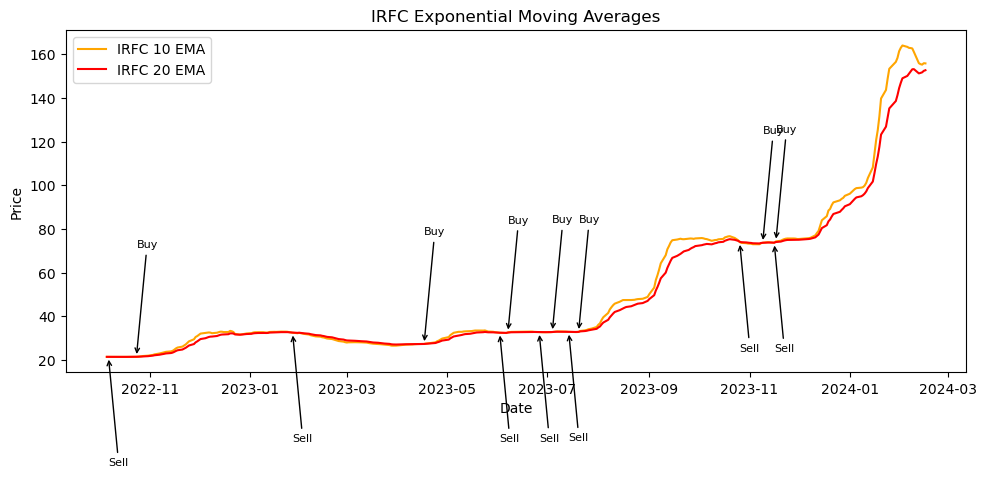

IRFC Transactions:
Buy Price: 21.6
Sell Price: 21.35
Return Percentage: -1.16%

Buy Price: 27.5
Sell Price: 31.3
Return Percentage: 13.82%

Buy Price: 33.85
Sell Price: 32.0
Return Percentage: -5.47%

Buy Price: 33.2
Sell Price: 32.3
Return Percentage: -2.71%

Buy Price: 33.3
Sell Price: 32.6
Return Percentage: -2.10%

Buy Price: 74.6
Sell Price: 70.2
Return Percentage: -5.90%

Buy Price: 76.9
Sell Price: 73.1
Return Percentage: -4.94%

IRFC Cumulative Return: -4.94%


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from SmartApi import SmartConnect
from pyotp import TOTP
import urllib
import json
import os
import datetime as dt

# Change directory to the location where the secret.txt file is stored
key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)

# Read API key and other secrets from secret.txt
key_secret = open("secret.txt", "r").read().split()

# Initialize SmartConnect object
obj = SmartConnect(api_key=key_secret[0])

# Generate session
data = obj.generateSession(key_secret[2], key_secret[3], TOTP(key_secret[4]).now())

# Fetch instrument list
instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())

def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["token"]
        
def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[-1] == "EQ":
            return instrument["name"]

def hist_data(tickers, duration, interval, instrument_list, exchange="NSE"):
    hist_data_tickers = {} 
    for ticker in tickers:
        params = {
                 "exchange": exchange,
                 "symboltoken": token_lookup(ticker, instrument_list),
                 "interval": interval,
                 "fromdate": (dt.date.today() - dt.timedelta(duration)).strftime('%Y-%m-%d %H:%M'),
                 "todate": dt.datetime.now().strftime('%Y-%m-%d %H:%M')  
                 }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns = ["date","open","high","low","close","volume"])
        df_data.set_index("date", inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers

# Calculate Exponential Moving Average (EMA)
def calculate_ema(data, window):
    ema = data.ewm(span=window, adjust=False).mean()
    return ema

# Function to get user input for stock names
def get_stock_names():
    stock_names = input("Enter the stock names separated by comma (e.g., ADANIENT,HCLTECH): ")
    return stock_names.split(",")

# Get user input for stock names
stocks = get_stock_names()

# Fetch historical candle data for specified tickers
candle_data = hist_data(stocks, 500, "ONE_DAY", instrument_list)

# Track buy and sell prices without time
buy_prices = {}
sell_prices = {}

# Track buy and sell transactions and their corresponding prices
buy_transactions = {}
sell_transactions = {}

for stock in stocks:
    # Calculate 10 EMA and 20 EMA
    ema_10 = calculate_ema(candle_data[stock]["close"], window=10)
    ema_20 = calculate_ema(candle_data[stock]["close"], window=20)

    # Track buy and sell transactions
    buy_transactions[stock] = []
    sell_transactions[stock] = []

    # Plot EMA
    plt.figure(figsize=(10, 5))  # Adjust figure size
    plt.plot(ema_10.index, ema_10, label=f"{stock} 10 EMA", color="orange")
    plt.plot(ema_20.index, ema_20, label=f"{stock} 20 EMA", color="red")

    # Add Buy and Sell signals
    for i in range(1, len(ema_10)):
        if ema_10[i] > ema_20[i] and ema_10[i - 1] <= ema_20[i - 1]:
            plt.annotate('Buy', xy=(ema_10.index[i], ema_10[i]), xytext=(ema_10.index[i], ema_10[i] + 50),
                         arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=8)  # Adjust parameters
            buy_transactions[stock].append(ema_10.index[i])
        elif ema_10[i] < ema_20[i] and ema_10[i - 1] >= ema_20[i - 1]:
            plt.annotate('Sell', xy=(ema_10.index[i], ema_10[i]), xytext=(ema_10.index[i], ema_10[i] - 50),
                         arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=8)  # Adjust parameters
            sell_transactions[stock].append(ema_10.index[i])

    plt.title(f"{stock} Exponential Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Print buy and sell transactions without time
for stock in stocks:
    print(f"{stock} Transactions:")
    for buy_date, sell_date in zip(buy_transactions[stock], sell_transactions[stock]):
        buy_price = candle_data[stock].loc[buy_date, "close"]
        sell_price = candle_data[stock].loc[sell_date, "close"]
        buy_prices[stock] = buy_price
        sell_prices[stock] = sell_price
        percentage_return = ((sell_price - buy_price) / buy_price) * 100
        print(f"Buy Price: {buy_price}")
        print(f"Sell Price: {sell_price}")
        print(f"Return Percentage: {percentage_return:.2f}%")
        print()

# Calculate cumulative return percentage for each stock
cumulative_returns = {}
for stock in stocks:
    cumulative_returns[stock] = ((sell_prices[stock] - buy_prices[stock]) / buy_prices[stock]) * 100
    print(f"{stock} Cumulative Return: {cumulative_returns[stock]:.2f}%")

In [7]:
#News

In [2]:
!pip install newsapi-python
from newsapi import NewsApiClient

# Init
newsapi = NewsApiClient(api_key='e503d2b9c36e41438e8a0ab41bc483a2')

# /v2/top-headlines
top_headlines = newsapi.get_top_headlines(q='Stock market',
                                          category='business',
                                          language='en',
                                          country='in')

# /v2/everything
all_articles = newsapi.get_everything(q='Stock market',
                                      language='en',
                                      sort_by='relevancy',
                                      page=2)

# /v2/top-headlines/sources
sources = newsapi.get_sources()

print(top_headlines)

  Obtaining dependency information for newsapi-python from https://files.pythonhosted.org/packages/74/47/e3b099102f0c826d37841d2266e19f1568dcf58ba86e4c6948e2a124f91d/newsapi_python-0.2.7-py2.py3-none-any.whl.metadata
{'status': 'ok', 'totalResults': 3, 'articles': [{'source': {'id': 'the-times-of-india', 'name': 'The Times of India'}, 'author': 'Nikhil Agarwal', 'title': 'BPCL shares rally over 4% on upgrade by Jefferies, target price set at Rs 890 - The Economic Times', 'description': 'Jefferies upgraded BPCL stock due to a steep discount and less impact from marketing losses in diesel till national elections. Target price of Rs 890 set, valuing it at 2.8x fwd P/B for 14% ROE in FY25.', 'url': 'https://economictimes.indiatimes.com/markets/stocks/news/bpcl-shares-rally-over-4-on-upgrade-by-jefferies-target-price-set-at-rs-890/articleshow/107742575.cms', 'urlToImage': 'https://img.etimg.com/thumb/msid-107742528,width-1200,height-630,imgsize-28520,overlay-etmarkets/photo.jpg', 'published

In [6]:
#Screener

In [8]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

url = "https://chartink.com/screener/process"

condition = {"scan_clause" : "( {cash} ( latest rsi( 9 ) > latest wma( latest rsi( 9 ) , 21 ) and 1 day ago  rsi( 9 ) <= 1 day ago  wma( latest rsi( 9 ) , 21 ) and latest rsi( 9 ) > 70 and market cap > 1500 ) ) "}

with requests.session() as s:
    r_data = s.get(url)
    soup = bs(r_data.content, "lxml")
    meta = soup.find("meta", {"name" : "csrf-token"})["content"]

    header = {"x-csrf-token" : meta}
    data = s.post(url, headers=header, data=condition).json()

    stock_list = pd.DataFrame(data["data"])
    print(stock_list["nsecode"].to_list())

['PERSISTENT', 'DRREDDY', 'VADILALIND', 'INGERRAND', 'YASHO', 'ADANIPORTS', 'IPCALAB', 'TATAMOTORS', 'KIRLPNU', 'TATAMTRDVR', 'INDHOTEL', 'RAIN', 'PAISALO', 'CONFIPET']


In [9]:
from SmartApi import SmartConnect
import os
import datetime as dt
from pyotp import TOTP
import urllib
import pandas as pd
import json
import threading
from statistics import mean
import time

# Initialize SmartAPI
key_path = r'C:\Users\sarda\Desktop'
os.chdir(key_path)
key_secret = open("secret.txt", "r").read().split()
obj = SmartConnect(api_key=key_secret[0])
data = obj.generateSession(key_secret[2], key_secret[3], TOTP(key_secret[4]).now())
feed_token = obj.getfeedToken()

# Fetch instrument list
instrument_url = "https://margincalculator.angelbroking.com/OpenAPI_File/files/OpenAPIScripMaster.json"
response = urllib.request.urlopen(instrument_url)
instrument_list = json.loads(response.read())

tickers = ["WIPRO", "ULTRACEMCO", "UPL", "TITAN", "TECHM", "TATASTEEL", "TATAMOTORS",
           "TATACONSUM", "TCS", "SUNPHARMA", "SBIN", "SBILIFE", "RELIANCE", "POWERGRID",
           "ONGC", "NESTLEIND", "NTPC", "MARUTI", "M&M", "LT", "KOTAKBANK", "JSWSTEEL",
           "INFY", "INDUSINDBK", "ITC", "ICICIBANK", "HDFC", "HINDUNILVR", "HINDALCO",
           "HEROMOTOCO", "HDFCLIFE", "HDFCBANK", "HCLTECH", "GRASIM", "EICHERMOT",
           "DRREDDY", "DIVISLAB", "COALINDIA", "CIPLA", "BRITANNIA", "BHARTIARTL",
           "BPCL", "BAJAJFINSV", "BAJFINANCE", "BAJAJ-AUTO", "AXISBANK", "ASIANPAINT",
           "APOLLOHOSP", "ADANIPORTS", "ADANIENT"]

bktst_start_dt = "2022-05-21 09:15"
bktst_end_dt = "2022-10-21 15:30"


def token_lookup(ticker, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["name"] == ticker and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["token"]


def symbol_lookup(token, instrument_list, exchange="NSE"):
    for instrument in instrument_list:
        if instrument["token"] == token and instrument["exch_seg"] == exchange and instrument["symbol"].split('-')[
            -1] == "EQ":
            return instrument["name"]


def hist_data_daily(tickers, instrument_list, exchange="NSE"):
    hist_data_tickers = {}
    for ticker in tickers:
        time.sleep(0.3)
        params = {
            "exchange": exchange,
            "symboltoken": token_lookup(ticker, instrument_list),
            "interval": "ONE_DAY",
            "fromdate": bktst_start_dt,
            "todate": bktst_end_dt
        }
        hist_data = obj.getCandleData(params)
        df_data = pd.DataFrame(hist_data["data"],
                               columns=["date", "open", "high", "low", "close", "volume"])
        df_data.set_index("date", inplace=True)
        df_data.index = pd.to_datetime(df_data.index)
        df_data.index = df_data.index.tz_localize(None)
        df_data["gap"] = ((df_data["open"] / df_data["close"].shift(1)) - 1) * 100
        df_data["avvol"] = df_data["volume"].rolling(10).mean().shift(1)
        hist_data_tickers[ticker] = df_data
    return hist_data_tickers


def hist_data_intraday(ticker, datestamp, interval, instrument_list, exchange="NSE"):
    params = {
        "exchange": exchange,
        "symboltoken": token_lookup(ticker, instrument_list),
        "interval": interval,
        "fromdate": datestamp.strftime("%Y-%m-%d") + " 09:15",
        "todate": datestamp.strftime("%Y-%m-%d") + " 15:30"
    }
    hist_data = obj.getCandleData(params)
    df_data = pd.DataFrame(hist_data["data"],
                           columns=["date", "open", "high", "low", "close", "volume"])
    df_data.set_index("date", inplace=True)
    df_data.index = pd.to_datetime(df_data.index)
    df_data.index = df_data.index.tz_localize(None)
    return df_data


candle_data = hist_data_daily(tickers, instrument_list)


def topGap(data):
    top_gap_by_date = {}
    dates = data[tickers[0]].index.to_list()
    for date in dates:
        temp = pd.Series()
        for ticker in data:
            try:
                temp.loc[ticker] = data[ticker].loc[date, "gap"]
            except:
                pass
        top_gap_by_date[date] = (abs(temp[abs(temp) > 1.5])).sort_values(ascending=False)[:5].index.to_list()
        print("top 5 gap stocks on {}".format(date))
        print((abs(temp[abs(temp) > 1.5])).sort_values(ascending=False)[:5])

    return top_gap_by_date


top_gap_by_date = topGap(candle_data)


def backtest(top_gap_by_date, candle_data):
    date_stats = {}
    for date in top_gap_by_date:
        date_orgnl = date.strftime("%Y-%m-%d %H:%M")
        date_stats[date] = {}
        for ticker in top_gap_by_date[date]:
            try:
                intraday_df = hist_data_intraday(ticker, date, 'FIVE_MINUTE', instrument_list)
                hi_price = intraday_df.iloc[0]['high']
                lo_price = intraday_df.iloc[0]['low']
                open_price = ''
                direction = ''
                date_stats[date][ticker] = 0
                for i in range(1, len(intraday_df[1:])):
                    if intraday_df.iloc[i]["volume"] > 2 * (
                            candle_data[ticker].loc[date_orgnl, "avvol"]) / 75 \
                            and intraday_df.iloc[i]["high"] > hi_price \
                            and open_price == '':
                        open_price = 0.8 * intraday_df.iloc[i + 1]["open"] + 0.2 * intraday_df.iloc[i + 1][
                            "high"]  # factoring in slippage
                        direction = 'long'
                    elif intraday_df.iloc[i]["volume"] > 2 * (
                            candle_data[ticker].loc[date_orgnl, "avvol"]) / 75 \
                            and intraday_df.iloc[i]["low"] < lo_price \
                            and open_price == '':
                        open_price = 0.8 * intraday_df.iloc[i + 1]["open"] + 0.2 * intraday_df.iloc[i + 1][
                            "low"]  # factoring in slippage
                        direction = 'short'

                    if open_price != '' and direction == 'long':
                        if intraday_df.iloc[i]["high"] > hi_price * 1.05:
                            ticker_return = ((hi_price * 1.05) / open_price) - 1
                            date_stats[date][ticker] = ticker_return
                            break
                        elif intraday_df.iloc[i]["low"] < lo_price:
                            ticker_return = (lo_price / open_price) - 1
                            date_stats[date][ticker] = ticker_return
                            break
                        else:
                            ticker_return = (intraday_df.iloc[i]["close"] / open_price) - 1
                            date_stats[date][ticker] = ticker_return

                    if open_price != '' and direction == 'short':
                        if intraday_df.iloc[i]["low"] < lo_price * 0.95:
                            ticker_return = 1 - ((lo_price * 0.95) / open_price)
                            date_stats[date][ticker] = ticker_return
                            break
                        elif intraday_df.iloc[i]["high"] > hi_price:
                            ticker_return = 1 - (hi_price / open_price)
                            date_stats[date][ticker] = ticker_return
                            break
                        else:
                            ticker_return = 1 - (intraday_df.iloc[i]["close"] / open_price)
                            date_stats[date][ticker] = ticker_return
            except:
                print(ticker, date)

    return date_stats


date_stats = backtest(top_gap_by_date, candle_data)

###########################KPIs#####################################


def abs_return(date_stats):
    df = pd.DataFrame(date_stats).T
    df["ret"] = df.mean(axis=1)
    df["ret"].fillna(0, inplace=True)
    return (1 + df["ret"]).cumprod().iloc[-1] - 1


def win_rate(date_stats):
    win_count = 0
    lose_count = 0
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] > 0:
                win_count += 1
            elif date_stats[i][ticker] < 0:
                lose_count += 1
    return (win_count / (win_count + lose_count)) * 100


def mean_ret_winner(date_stats):
    win_ret = []
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] > 0:
                win_ret.append(date_stats[i][ticker])
    return sum(win_ret) / len(win_ret)


def mean_ret_loser(date_stats):
    los_ret = []
    for i in date_stats:
        for ticker in date_stats[i]:
            if date_stats[i][ticker] < 0:
                los_ret.append(date_stats[i][ticker])
    return sum(los_ret) / len(los_ret)


def equity_curve(date_stats):
    df = pd.DataFrame(date_stats).T
    df["ret"] = df.mean(axis=1)
    df["ret"].fillna(0, inplace=True)
    df["cum_ret"] = (1 + df["ret"]).cumprod() - 1
    df["cum_ret"].plot(title="return profile")


def calculate_portfolio_return(date_stats, initial_capital):
    total_return = 0
    for date in date_stats:
        for ticker, return_rate in date_stats[date].items():
            total_return += return_rate
    return initial_capital * total_return


# Initial capital
initial_capital = 100000

# Calculate portfolio return
portfolio_return = calculate_portfolio_return(date_stats, initial_capital)
print("Portfolio Return: Rs.", portfolio_return)

# Rebalance portfolio using the return
new_portfolio_value = initial_capital + portfolio_return
print("Total capital now: Rs.", new_portfolio_value)
# Sort the stocks based on their performance
sorted_stocks = {}
for date in date_stats:
    for ticker, return_rate in date_stats[date].items():
        if ticker not in sorted_stocks:
            sorted_stocks[ticker] = return_rate
        else:
            sorted_stocks[ticker] += return_rate

sorted_stocks = {k: v for k, v in sorted(sorted_stocks.items(), key=lambda item: item[1], reverse=True)}

# Reallocate capital to top 7 performing stocks
top_performing_stocks = list(sorted_stocks.keys())[:6]
allocation_per_stock = (0.6*new_portfolio_value) / len(top_performing_stocks)

print("Reallocated capital:")
for stock in top_performing_stocks:
    print(stock, ":", allocation_per_stock)
    
print("Capital allocated to commodities:",0.12*new_portfolio_value)
print("Capital allocated to bonds:",0.1*new_portfolio_value)
print("Capital allocated to mutual funds:",0.18*new_portfolio_value)

print("% return on commodities like Gold and Silver: 10%")
print("% return on mutual funds: 20%")
print("% return on bonds: 7%")

print("Return gained by commodities after one year:",0.1*0.12*new_portfolio_value)
print("Return gained by mutual funds:",0.2*0.1*new_portfolio_value)
print("Return gained by bonds:",0.07*0.12*new_portfolio_value)

print("Total value gained by other asset classes: ",round(0.1 * 0.12 * new_portfolio_value + 0.2 * 0.1 * new_portfolio_value + 0.07 * 0.12 * new_portfolio_value, 2))

[I 240218 07:28:05 smartConnect:113] in pool


top 5 gap stocks on 2022-10-19 00:00:00
Series([], dtype: object)
top 5 gap stocks on 2022-10-20 00:00:00
HINDALCO    1.870356
dtype: float64
top 5 gap stocks on 2022-10-21 00:00:00
AXISBANK    4.147242
dtype: float64
Portfolio Return: Rs. 0
Total capital now: Rs. 100000
Reallocated capital:
HINDALCO : 30000.0
AXISBANK : 30000.0
Capital allocated to commodities: 12000.0
Capital allocated to bonds: 10000.0
Capital allocated to mutual funds: 18000.0
% return on commodities like Gold and Silver: 10%
% return on mutual funds: 20%
% return on bonds: 7%
Return gained by commodities after one year: 1200.0
Return gained by mutual funds: 2000.0000000000005
Return gained by bonds: 840.0000000000001
Total value gained by other asset classes:  4040.0
